2.0.1+cu118


100%|██████████| 9912422/9912422 [00:00<00:00, 46179841.44it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 24309792.06it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 12124931.88it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 19969107.72it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

60000
torch.Size([64, 1, 28, 28])
torch.Size([64])


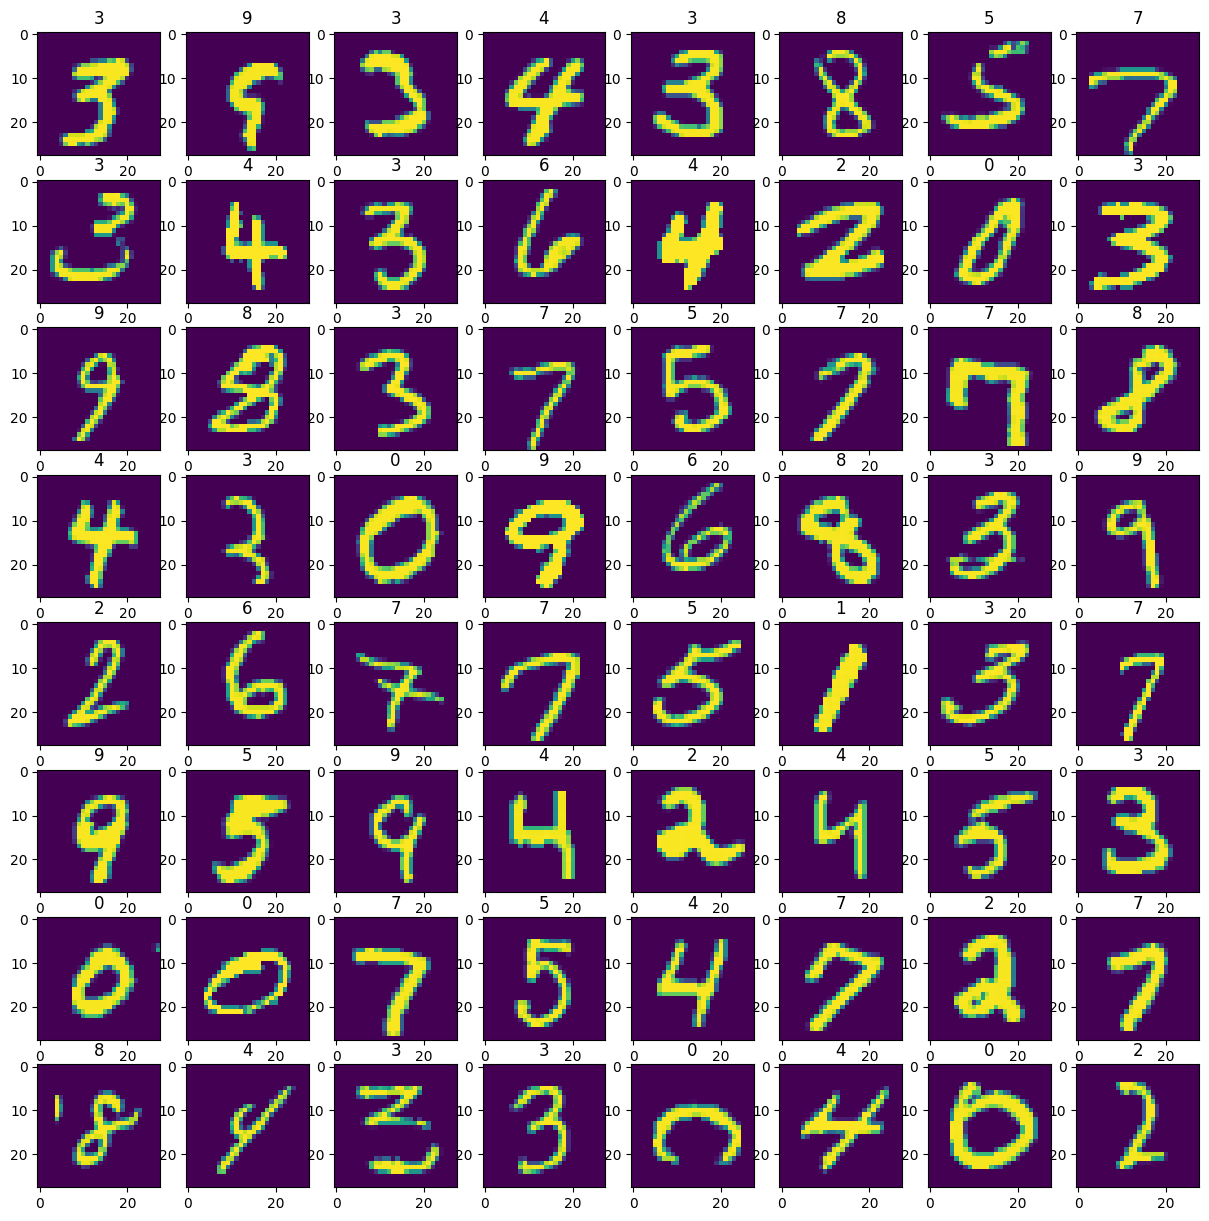

In [1]:
import torch
import torch.nn as nn
import torchvision.datasets as ds
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor, Normalize, Compose
import matplotlib.pyplot as plt
from tqdm.auto import trange, tqdm
print(torch.__version__)

MNIST = ds.MNIST(root="./data", train=True, download=True, transform=Compose([ToTensor(), Normalize([0.5], [0.5])]))
dataloader_train = DataLoader(MNIST, batch_size=64, shuffle=True)
MNIST2 = ds.MNIST(root="./data", train=False, download=True, transform=Compose([ToTensor(), Normalize([0.5], [0.5])]))
dataloader_test = DataLoader(MNIST2, batch_size=64, shuffle=True)
print(len(MNIST))

device = "cuda" if torch.cuda.is_available() else "cpu"
batch, labels = next(iter(dataloader_train))
print(batch.shape)
print(labels.shape)

plt.figure(figsize=[15,15])
for i in range(64):
    plt.subplot(8,8,i+1)
    plt.imshow(batch[i].squeeze().detach().numpy())
    plt.title(labels[i].item())
plt.show()


In [2]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 8, 3)
        self.conv2 = nn.Conv2d(8, 16, 3)
        self.conv3 = nn.Conv2d(16, 8, 3)
        self.bn1 = nn.BatchNorm2d(8)
        self.bn2 = nn.BatchNorm2d(16)
        self.bn3 = nn.BatchNorm2d(8)
        self.act = nn.ReLU()
        self.pool = nn.MaxPool2d(2)
        self.fc = nn.Linear(4*4*8, 10)

    def forward(self, x):
        out1 = self.bn1(self.pool(self.act(self.conv1(x))))
        out2 = self.bn2(self.act(self.conv2(out1)))
        out3 = self.bn3(self.pool(self.act(self.conv3(out2))))
        out = self.fc(out3.flatten(start_dim=-3, end_dim=-1))
        return out1, out2, out3, out
        


Epoch 1/5


  0%|          | 0/938 [00:00<?, ?it/s]

Loss: 0.34907886385917664
Accuracy: 0.8931833505630493
Epoch 2/5


  0%|          | 0/938 [00:00<?, ?it/s]

Loss: 0.11231564730405807
Accuracy: 0.9661333560943604
Epoch 3/5


  0%|          | 0/938 [00:00<?, ?it/s]

Loss: 0.084923654794693
Accuracy: 0.9746999740600586
Epoch 4/5


  0%|          | 0/938 [00:00<?, ?it/s]

Loss: 0.0738411396741867
Accuracy: 0.977649986743927
Epoch 5/5


  0%|          | 0/938 [00:00<?, ?it/s]

Loss: 0.0654059648513794
Accuracy: 0.9799333214759827


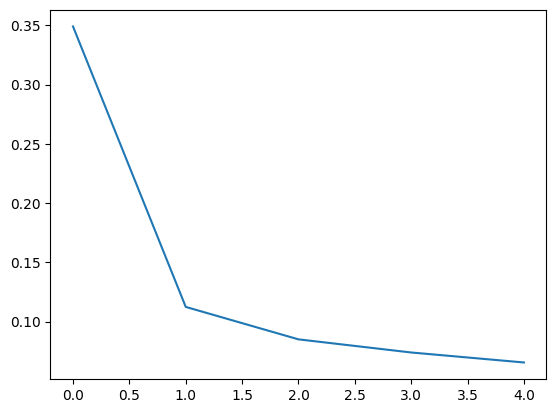

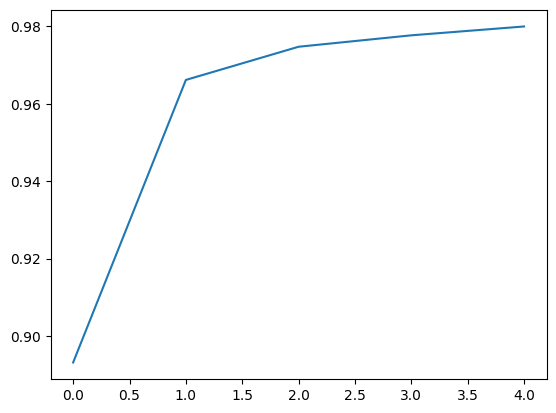

In [14]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
model = CNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
n_epochs = 3
criterion = nn.CrossEntropyLoss()
for epoch in range(n_epochs):
    #print(f"Epoch {epoch+1}/{n_epochs}")
    model.train()
    l = 0
    a = 0
    trainbar = tqdm(dataloader_train)
    count = 0
    for img, label in trainbar:
        optimizer.zero_grad()
        img, label = img.to(device), label.to(device)
        *_, output = model(img)
        #print(output.shape)
        loss = criterion(output, label)
        l += loss.item()
        loss.backward()
        optimizer.step()
        acc = torch.sum(torch.argmax(output, dim=-1)==label).item()
        a += acc
        count += len(img)
        trainbar.set_description(f"Training Epoche {epoch+1}/{n_epochs}, Loss: {l/count:.4f}, Acc: {a/count*100:.2f}%")
    
    model.eval()
    l = 0
    a = 0
    testbar = tqdm(dataloader_test)
    count = 0
    for img, label in testbar:
        img, label = img.to(device), label.to(device)
        with torch.no_grad():
            *_, output = model(img)
        loss = criterion(output, label)
        l += loss.item()
        acc = torch.sum(torch.argmax(output, dim=-1)==label).item()
        a += acc
        count += len(img)
        testbar.set_description(f"Testing Epoche {epoch+1}/{n_epochs}, Loss: {l/count:.4f}, Acc: {a/count*100:.2f}%")


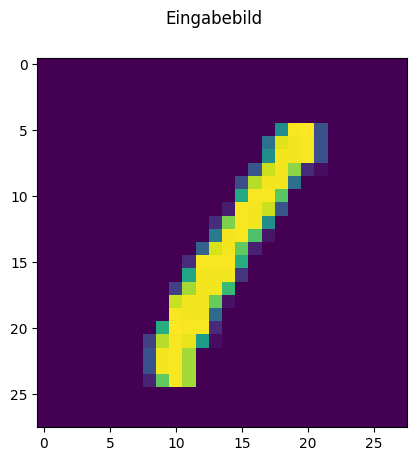

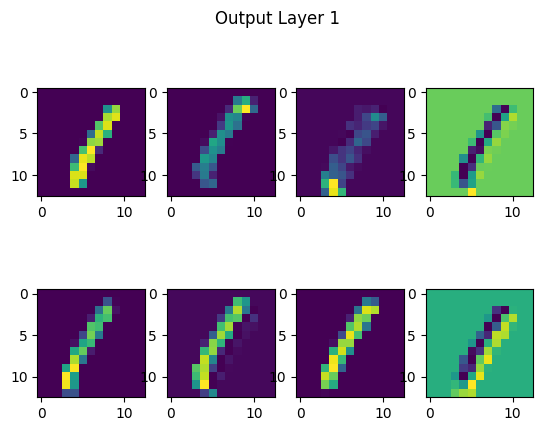

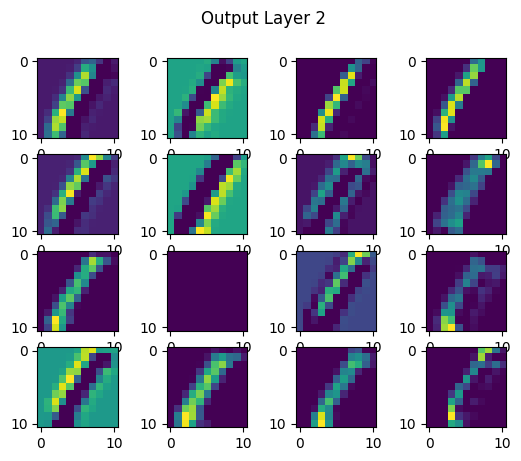

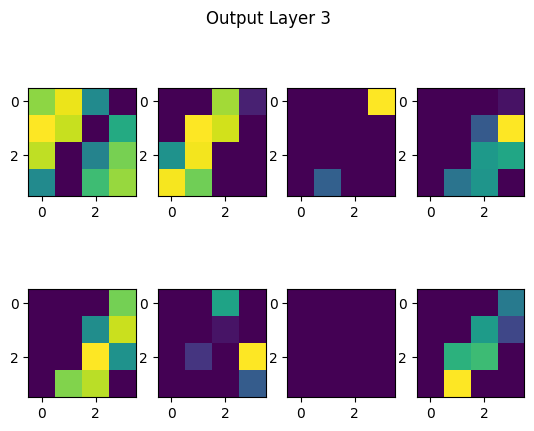

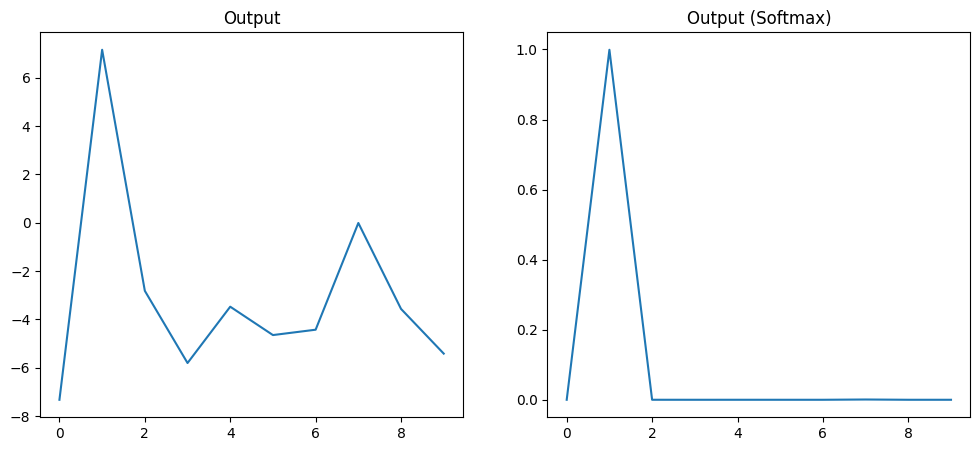

In [58]:
# --- Hier kann der Index geändert werden
# Beispiel:
# idx = 1: 0
# idx = 3: 1
# idx = 5: 2
# idx = 7: 3
# idx = 2: 4
# idx = 0: 5
# idx = 13: 6
# idx = 15: 7
# idx = 17: 8
# idx = 4: 9

idx = 3
# -----
img, label = MNIST[idx]

out1, out2, out3, output = model(img.to(device))
plt.figure()
plt.imshow(img[0].detach().cpu().numpy())
plt.suptitle("Eingabebild")
plt.show()

plt.figure()
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(out1[i].detach().cpu().numpy())
plt.suptitle("Output Layer 1")
plt.show()

plt.figure()
for i in range(16):
    plt.subplot(4,4,i+1)# --- Hier kann der Index geändert werden
# Beispiel:
# idx = 1: 0
# idx = 3: 1
# idx = 5: 2
# idx = 7: 3
# idx = 2: 4
# idx = 0: 5
# idx = 13: 6
# idx = 15: 7
# idx = 17: 8
# idx = 4: 9

idx = 0
# -----
img, label = MNIST[idx]

out1, out2, out3, output = model(img.to(device).unsqueeze(0))
plt.figure()
plt.imshow(img[0].detach().cpu().numpy())
plt.suptitle("Eingabebild")
plt.show()

plt.figure()
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(out1.squeeze()[i].detach().cpu().numpy())
plt.suptitle("Output Layer 1")
plt.show()

plt.figure()
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(out2.squeeze()[i].detach().cpu().numpy())
plt.suptitle("Output Layer 2")
plt.show()

plt.figure()
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(out3.squeeze()[i].detach().cpu().numpy())
plt.suptitle("Output Layer 3")
plt.show()

plt.figure(figsize=[12,5])
plt.subplot(1,2,1)
plt.plot(output.squeeze().detach().cpu().numpy())
plt.title("Output")
plt.subplot(1,2,2)
plt.plot(torch.nn.functional.softmax(output.squeeze(), dim=0).detach().cpu().numpy())
plt.title("Output (Softmax)")
plt.show()
    plt.imshow(out2[i].detach().cpu().numpy())
plt.suptitle("Output Layer 2")
plt.show()

plt.figure()
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(out3[i].detach().cpu().numpy())
plt.suptitle("Output Layer 3")
plt.show()

plt.figure(figsize=[12,5])
plt.subplot(1,2,1)
plt.plot(output.detach().cpu().numpy())
plt.title("Output")
plt.subplot(1,2,2)
plt.plot(torch.nn.functional.softmax(output, dim=0).detach().cpu().numpy())
plt.title("Output (Softmax)")
plt.show()

['T_destination', '__annotations__', '__call__', '__class__', '__constants__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_apply', '_backward_hooks', '_backward_pre_hooks', '_buffers', '_call_impl', '_conv_forward', '_forward_hooks', '_forward_hooks_with_kwargs', '_forward_pre_hooks', '_forward_pre_hooks_with_kwargs', '_get_backward_hooks', '_get_backward_pre_hooks', '_get_name', '_is_full_backward_hook', '_load_from_state_dict', '_load_state_dict_post_hooks', '_load_state_dict_pre_hooks', '_maybe_warn_non_full_backward_hook', '_modules', '_named_members', '_non_persistent_buffers_set', '_parameters', '_register_load_state_dict_pre_hook', '_register_state_dict_hook', '_re

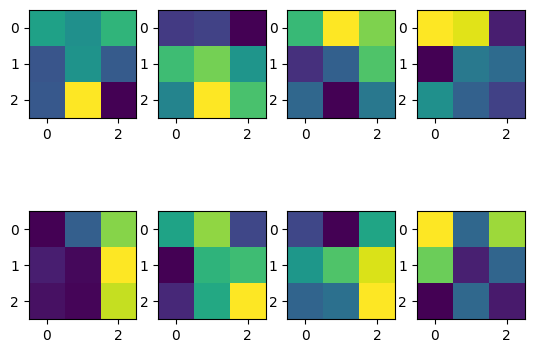

In [57]:
print(dir(model.conv1))
kernellist = model.conv1.weight
plt.figure()
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(kernellist[i,0].detach().cpu().numpy())
plt.show()